# Setup

In [16]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
# Open the file in write mode
with open('/usr/local/lib/python3.9/dist-packages/efficientnet/keras.py', 'r') as f:
    # Read the contents of the file
    contents = f.read()

# Replace the string
new_contents = contents.replace('init_keras_custom_objects', 'init_tfkeras_custom_objects')

# Open the file in write mode again and write the modified contents
with open('/usr/local/lib/python3.9/dist-packages/efficientnet/keras.py', 'w') as f:
    f.write(new_contents)

In [18]:
!pip3 install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 

# Imports

In [19]:
# system
import os

# calculation
import numpy as np 
import random

# image processing & data
import cv2
from PIL import Image 

# model 
from keras import backend as K
import segmentation_models as sm
from keras.models import load_model

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# deploy
import gradio as gr

Segmentation Models: using `keras` framework.


# Evaluation Metric

In [20]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

# Loss Function

In [21]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Model

In [22]:
satellite_model = load_model("/content/model.hdf5",custom_objects={'dice_loss_plus_1focal_loss': total_loss,'jacard_coef':jaccard_coef})

In [24]:
# satellite_model.get_config()

# Prediction

1/1 [==============================] - 1s 1s/step


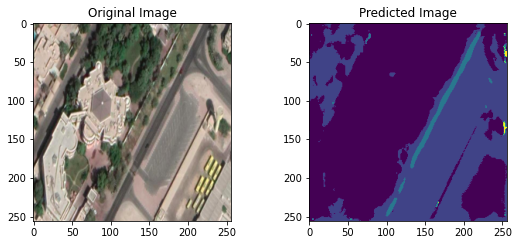

In [26]:
image = Image.open('/content/test2.jpg')
image = image.convert('RGB') # convert to RGB format
image = image.resize((256, 256))
image = np.array(image)
image = np.expand_dims(image, 0)
prediction = satellite_model.predict(image)

predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

temp_orig_img=Image.open('/content/test2.jpg')
temp_orig_img = temp_orig_img.resize((256, 256))

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(temp_orig_img)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

# Gradio UI 

In [35]:
def process_input_image(image_source):
    if image_source is None:
        return 'Error', 'Input image is None'
    
    image = np.array(image_source)
    if image.dtype == np.uint8:
        image = image.astype(np.float32) / 255.0
    
    image = np.nan_to_num(image, nan=0.0)
    image = np.expand_dims(image, 0)
    
    prediction = satellite_model.predict(image)
    predicted_image = np.argmax(prediction, axis=3)

    predicted_image = predicted_image[0,:,:]
    predicted_image = predicted_image * 50
    predicted_image = predicted_image.astype(np.uint8)

    return 'Predicted Masked Image', predicted_image

In [36]:
my_app = gr.Blocks()

with my_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image", shape=(256, 256))
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [37]:
my_app.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 287ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 394, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1078, in process_api
    data = self.postprocess_data(fn_index, result["prediction"], state)
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1012, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
  File "/usr/local/lib/python3.9/dist-packages/gradio/components.py", line 1634, in postprocess
    return processing_utils.encode_url_or_file_to_base64(y)
  File "/usr/local/lib/python3.9/dist-packages/gradio/processing_utils.py", line 70, in encode_url_or_file_to_base64
    return encode_file_to_base64(path)
  File "/usr/local/lib/python3.9/dist-packages/gradio/processing_utils.py", line 94, in encode_file_to_base64
    with open(f, "rb") as file:
FileNotFoundError: [Errno 2] No such file or direct

1/1 [==============================] - 0s 165ms/step
Keyboard interruption in main thread... closing server.


In [38]:
my_app.close()

Closing server running on port: 7860
